In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from matplotlib import pyplot as plt

src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/src')
sys.path.append(str(src_path))

In [2]:
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False


In [3]:
import disp_xr
from disp_xr import product, stack as disp_stack, utils, quality_metrics, io
from disp_xr.mintpy_utils.utils import find_reference_point 
from pyproj import Transformer

In [4]:
def get_bounds(xr_data):
    x_min, x_max = xr_data.x.min().item(), xr_data.x.max().item()
    y_min, y_max = xr_data.y.min().item(), xr_data.y.max().item()
    return (x_min, x_max, y_min, y_max)

import matplotlib.patches as patches
def plot_chunk_location(ax, stack_xr: xr.Dataset, 
                        block:tuple, annot_txt:str, zorder:int=1):
    # Get coordinates 
    start_y = stack_xr.isel(y=block[1]).y.data[0]
    stop_y = stack_xr.isel(y=block[1]).y.data[-1]
    start_x = stack_xr.isel(x=block[2]).x.data[0]
    stop_x = stack_xr.isel(x=block[2]).x.data[-1]

    # Compute center of the rectangle
    center_x = (start_x + stop_x) / 2
    center_y = (start_y + stop_y) / 2

    # Create recangular
    rect = patches.Rectangle((start_x, start_y), 
                             stop_x - start_x, 
                             stop_y - start_y,
                             facecolor='none',
                             linewidth=1,
                             edgecolor='k',
                             zorder=zorder)
    
    # Plot 
    ax.add_patch(rect)

    # Annotate the center
    ax.text(center_x, center_y, str(annot_txt),
            ha="center", va="center", fontsize=8, zorder=zorder)   

In [5]:
# Get DISP version 0.10 data
disp_df = product.get_disp_info('/u/duvel-d0/ssangha/DISP_work/v10/F11116/products')

Found OPERA DISP: 254 products
 Starting date: 2016-07-05 14:07:55
 Ending date: 2022-09-08 14:08:36


 Number of reference dates: 7
 Skip 0 duplicates


In [6]:
%%time
stack = disp_stack.combine_disp_product(disp_df)

Stacking ministack into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


CPU times: user 8.98 s, sys: 1.46 s, total: 10.4 s
Wall time: 10.5 s


In [7]:
# REchunk it for better analysis performance
# NOTE: if not rechunked to merge time dim, map_block will give wrong outputs
stack2 = stack.copy()
stack2 = stack2.chunk({'time':-1})

# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)
print(len(chunks_ix))

266


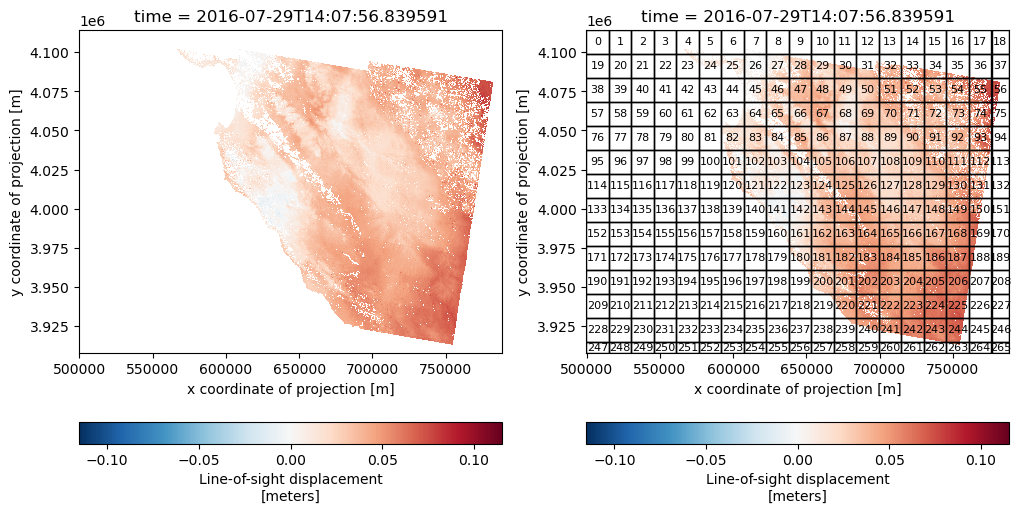

In [8]:
# Plot all chunks, take few min to plot chunk loc
# Skip this step if d
fig, ax = plt.subplots(1,2, figsize=(12,6))
cbar_kwargs={'orientation': 'horizontal'}

disp_epoch1_msk = stack.displacement.isel(time=0).where(stack.recommended_mask.isel(time=0)==1) 

disp_epoch1_msk.plot.imshow(ax=ax[0], cbar_kwargs=cbar_kwargs)
disp_epoch1_msk.plot.imshow(ax=ax[1], cbar_kwargs=cbar_kwargs)
for ix, block in enumerate(chunks_ix):
    plot_chunk_location(ax[1], stack, block, ix, zorder=1)

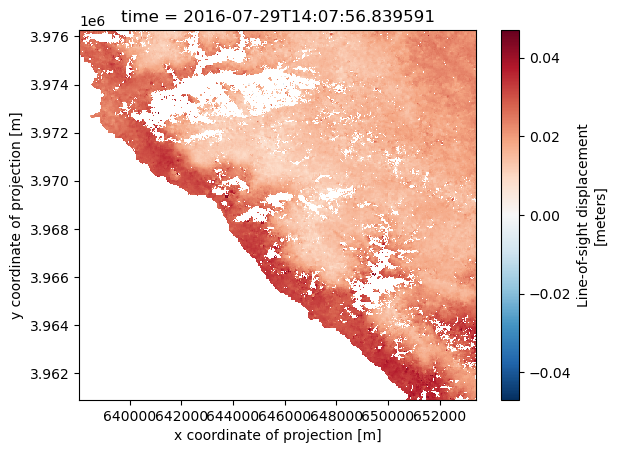

In [27]:
# Plot one chip for dev
ix =180 
mask = stack.recommended_mask[chunks_ix[ix]].isel(time=0)==1
stack.displacement[chunks_ix[ix]].isel(time=0).where(mask).plot.imshow()

In [10]:
with rasterio.open(f'NETCDF:"{str(disp_df.iloc[0].path)}":/displacement', 'r') as rd:
    crs = rd.crs
    gt = rd.transform.to_gdal()
    td = rd.transform 
    rows, cols = rd.shape


In [11]:
transformer = Transformer.from_crs(f'EPSG:{crs.to_epsg()}',
                                    "EPSG:4326",
                                    always_xy=True)

In [12]:
ref_y, ref_x = 3971445, 640245
jump_y, jump_x = 3971985, 639585

In [13]:
re_ref_data = stack2.displacement.sel(y=jump_y, x=jump_x, method='nearest') - stack2.displacement.sel(y=ref_y, x=ref_x, method='nearest') 

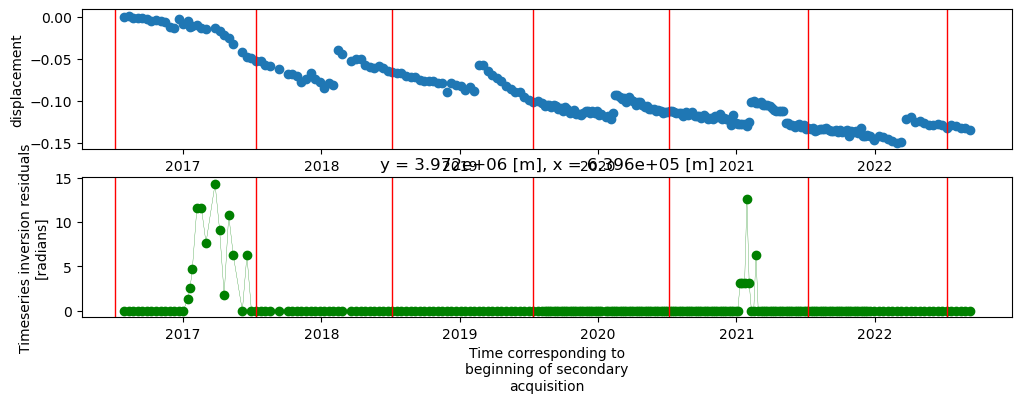

In [36]:
ref_dates = disp_xr.product._get_ministacks(disp_df)[1]
fig, ax = plt.subplots(2,1, figsize=(12,4))
re_ref_data.plot(ax=ax[0], marker='o', lw=0)
for p in ref_dates: ax[0].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

stack2.timeseries_inversion_residuals.sel(y=jump_y, x=jump_x, method='nearest').plot(ax=ax[1], marker='o', lw=0.2, color='green')
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

In [20]:
disp2phase = -4 * np.pi / 0.0566 
wrap = lambda x: np.mod((-4 *np.pi / 0.056 * x)+np.pi, 2*np.pi)-np.pi
wrap2pi = lambda x: np.mod((-4 *np.pi / 0.056 * x), 2*np.pi)
dif_data = re_ref_data.diff(dim='time').values
dif_phase = dif_data * disp2phase

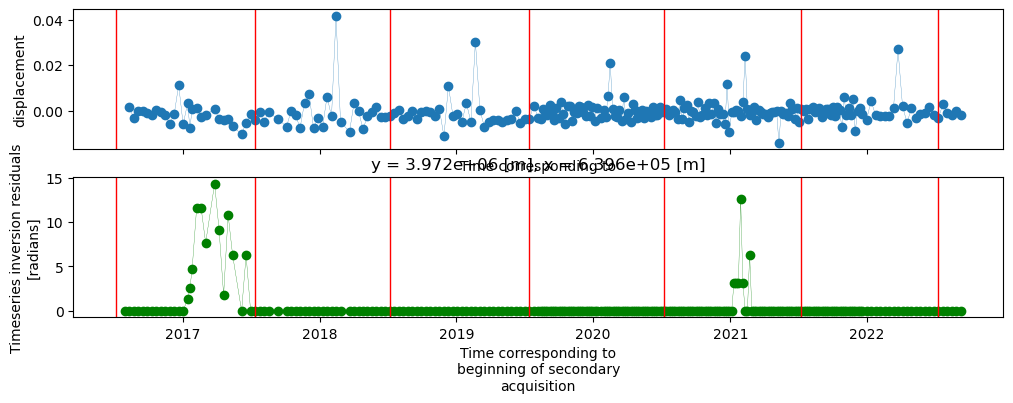

In [32]:
fig, ax = plt.subplots(2,1, figsize=(12,4), sharex=True)
re_ref_data.diff(dim='time', label='upper').plot(ax=ax[0], marker='o', lw=0.2)
for p in ref_dates: ax[0].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

stack2.timeseries_inversion_residuals.sel(y=jump_y, x=jump_x, method='nearest').plot(ax=ax[1], marker='o', lw=0.2, color='green')
for p in ref_dates: ax[1].axvline(pd.to_datetime(p, format='%Y%m%d'), color='r', lw=1)

Text(0, 0.5, 'radian')

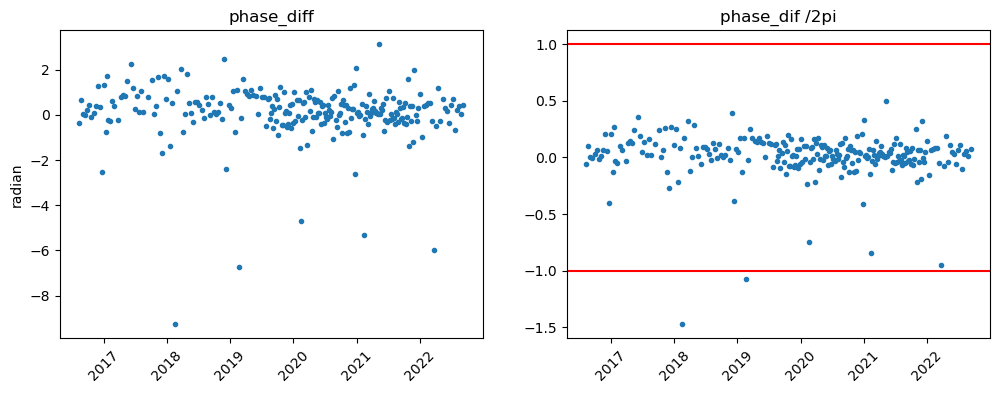

In [33]:
dt = re_ref_data.diff(dim='time').time
fig, ax = plt.subplots(1,2, figsize=(12, 4))
for a, d in zip(ax, [dif_phase,
                     dif_phase / (2*np.pi)]):
    a.plot(dt, d, '.')

# Print color hline 2pi
ax[1].axhline(-1, color='red')
ax[1].axhline(1, color='red')

for a, t in zip(ax, ['phase_diff', 'phase_dif /2pi']):
    a.set_title(t)
    a.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-ticks

ax[0].set_ylabel('radian')